In [48]:

import torch
# from tbparse import SummaryReader
from functools import partial
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import yaml
from tqdm import tqdm
# import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import \
    EventAccumulator
from tbparse import SummaryReader
from functools import reduce
from adjustText import adjust_text
# from tqdm.auto import tqdm  # for notebooks
from tqdm.notebook import tqdm
tqdm.pandas()
plt.rcParams.update({'font.size': 14})

# Overview: Load tensorboard files and plot them

Notebook to load in events files and plot them / save etc

## function development

In [63]:
# mapping of custom models to model names

def get_model_name(model_name_or_path:str) -> str:
    if "saved_models" in model_name_or_path:
        if "declutr" in model_name_or_path:
            if "few_epoch" in model_name_or_path:
                if "span_comparison" in model_name_or_path:
                    model_name = model_name_or_path.split("/")[9] + "/declutr/" + model_name_or_path.split("/")[-3]
                else:
                    model_name = model_name_or_path.split("/")[8] + "/declutr/" + model_name_or_path.split("/")[-3]

            else:
                model_name = model_name_or_path.split("/")[7] + "/declutr/" + model_name_or_path.split("/")[-3]
        elif "contrastive" in model_name_or_path or "custom_pretraining" in model_name_or_path:
            model_name = model_name_or_path.split("/")[7]
        elif "simcse" in model_name_or_path:# change this to be dynamic
            model_name = "simcse-mimic"
        else:
            model_name = model_name_or_path.split("/")[7]
    else:    
        model_name = model_name_or_path.split("/")[-1]
    
    return model_name

# an explicit mapping for paper model names

long_model_name_mappings = {
    "roberta-base": "RoBERTa-base",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_1": "RoBERTa-mimic-note",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_1_weighted":"RoBERTa-mimic-note",
    "roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted":"RoBERTa-mimic-note-two-epoch",
    "mimic-roberta-base": "RoBERTa-mimic",
    "roberta-base-2_anch_2_pos_min_1024": "RoBERTa-mimic-DeCLUTR",
    "mimic-roberta-base/declutr/2_anch_2_pos_min_1024": "Mimic-RoBERTa-DeCLUTR",
    "Bio_ClinicalBERT": "Bio-ClinicalBERT",
    "sts_trf_roberta": "ST-TRF-RoBERTa",
    "all-mpnet-base-v2 ": "all-mpnet-base-v2",
    "biobert-v1.1": "BioBERT",
    "Llama-2-7b-hf": "Llama-2-7b",
    }

# task name mappings

task_name_mappings = {"icd9-triage-no-category-in-text": "ICD9-Triage",
                      "icd9-triage": "ICD9-Triage",
                      "ICD9-Triage": "ICD9-Triage"}

def get_configs(logs_dir, modeldir):
    # try open but skip if doesn't exist
    try:
        with open(logs_dir + modeldir + '/config.yaml') as f:        
            configs= yaml.load(f, Loader=yaml.FullLoader)
    except IOError as e:
        print(e)
        configs = {}
    configs['dir_name'] = modeldir
    return configs

# function to read in event files given a logdir and return a dataframe with config merged

def read_tb_files(logdir):
    
    # first use summary reader
    reader = SummaryReader(f"{logdir}/", extra_columns={'dir_name'})
    df = reader.scalars
    
    # now load in config files

    config_list = df["dir_name"].drop_duplicates().progress_apply(
        lambda x: partial(get_configs, logdir)(x))
    config_df = pd.DataFrame.from_records(config_list)
    merged_df = pd.merge(df, config_df, on='dir_name')
    
    # we want to replace few_shot_n nan values with few_shot_n = "full"
    # check if few_shot_n is a column
    if "few_shot_n" in merged_df.columns:
        merged_df['few_shot_n'] = merged_df['few_shot_n'].fillna(250)
    
    # replace task name with mapping using replace function 
    merged_df['task'] = merged_df['task'].replace(task_name_mappings)

    # for now drop any that did not get a model name back i.e. config wasn't available
    merged_df = merged_df[merged_df['model_name_or_path'].notna()]

    # use model_name_or_path to get model name
    merged_df['Model name'] = merged_df['model_name_or_path'].progress_apply(lambda x: get_model_name(x))

    # now map to a more suitable name
    merged_df["Model name"] = merged_df["Model name"].replace(long_model_name_mappings)
    
    
    return merged_df

In [159]:
# def get_trainer_args(modeldir):
#     with open(logdir + modeldir + '/all_trainer_args.yaml') as f:
#         trainer_args= yaml.load(f, Loader=yaml.FullLoader)
#         trainer_args['dir_name'] = modeldir
#     return trainer_args

### Get number of trainable parameters for each model type



In [4]:
with open('../trainable_params.yaml', 'r') as f:
    trainable_params_mapping = yaml.load(f, yaml.FullLoader)


In [4]:
list(trainable_params_mapping.keys())

['/mnt/sdc/niallt/saved_models/declutr/mimic/few_epoch/mimic-roberta-base/2_anch_2_pos_min_1024/transformer_format/',
 '/mnt/sdc/niallt/saved_models/language_modelling/mimic/mimic-roberta-base/sampled_250000/22-12-2022--12-45/checkpoint-100000/',
 '/mnt/sdc/niallt/saved_models/language_modelling/mimic/roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted/sampled_250000/07-07-2023--08-30/checkpoint-30000/',
 'emilyalsentzer/Bio_ClinicalBERT',
 'meta-llama/Llama-2-7b-hf',
 'michiyasunaga/BioLinkBERT-base',
 'michiyasunaga/LinkBERT-base',
 'nlpie/bio-mobilebert',
 'nlpie/distil-biobert',
 'nlpie/tiny-biobert',
 'roberta-base']

### debugging

In [7]:
logdir = '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/'

reader = SummaryReader(logdir, extra_columns={'dir_name'})
df = reader.scalars


In [ ]:
config_list = df["dir_name"].drop_duplicates().apply(lambda x: partial(get_configs, logdir)(x))
config_df = pd.DataFrame.from_records(config_list)
df = pd.merge(df, config_df, on='dir_name')

[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2010-RE/full/tiny-biobert/PROMPT_TUNING/25-07-2023--10-01/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2014-NER/full/Bio_ClinicalBERT/Full/24-07-2023--11-47/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2014-NER/full/bio-mobilebert/LORA/25-07-2023--15-36/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2014-NER/full/distil-biobert/LORA/25-07-2023--15-35/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2014-NER/full/distil-biobert/PREFIX_TUNING/25-07-2023--17-14/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2014-NER/full/mimic-roberta-base/Full/24-07-2023--11-48/config.yaml'
[Errno 2] No such file or direc

In [16]:
df.peft_method.value_counts()

peft_method
LORA             71303
Full             60003
PROMPT_TUNING     9162
PREFIX_TUNING     3930
P_TUNING          2412
Name: count, dtype: int64

## Load in events files



In [50]:
logs_dir = '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/'
logs_df = read_tb_files(logs_dir)

  0%|          | 0/465 [00:00<?, ?it/s]

[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/ICD9-Triage/full/BioLinkBERT-base/PREFIX_TUNING/13-08-2023--13-44/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/ICD9-Triage/full/BioLinkBERT-base/PREFIX_TUNING/13-08-2023--21-47/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2010-RE/full/bio-mobilebert/PROMPT_TUNING/17-08-2023--16-59/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2010-RE/full/tiny-biobert/PROMPT_TUNING/25-07-2023--10-01/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2014-NER/full/BioLinkBERT-base/LORA/27-09-2023--09-16/config.yaml'
[Errno 2] No such file or directory: '/mnt/sdd/efficient_ml_data/saved_models/peft/logs/i2b2-2014-NER/full/Bio_ClinicalBERT/Full/24-07-2023--11-47/config.yaml'
[Errno 2] No suc

  0%|          | 0/393828 [00:00<?, ?it/s]

### investigate files

In [16]:
logs_df.head()

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,custom_model_name,data_dir,dropout,...,test_file,text_col,text_column,train_batch_size,training_data_dir,training_file,validation_file,warmup_steps,save_adapter,Model name
0,28,eval/accuracy,0.706808,ICD9-Triage/fewshot_128/roberta-base-mimic-not...,NaN,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,roberta-base-mimic-note-custom_pretraining_con...,,0.1,...,test.csv,text,text,32.0,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,valid.csv,100.0,NaN,roberta-base-mimic-note-custom_pretraining_con...
1,56,eval/accuracy,0.849711,ICD9-Triage/fewshot_128/roberta-base-mimic-not...,NaN,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,roberta-base-mimic-note-custom_pretraining_con...,,0.1,...,test.csv,text,text,32.0,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,valid.csv,100.0,NaN,roberta-base-mimic-note-custom_pretraining_con...
2,84,eval/accuracy,0.890173,ICD9-Triage/fewshot_128/roberta-base-mimic-not...,NaN,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,roberta-base-mimic-note-custom_pretraining_con...,,0.1,...,test.csv,text,text,32.0,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,valid.csv,100.0,NaN,roberta-base-mimic-note-custom_pretraining_con...
3,112,eval/accuracy,0.905588,ICD9-Triage/fewshot_128/roberta-base-mimic-not...,NaN,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,roberta-base-mimic-note-custom_pretraining_con...,,0.1,...,test.csv,text,text,32.0,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,valid.csv,100.0,NaN,roberta-base-mimic-note-custom_pretraining_con...
4,140,eval/accuracy,0.894348,ICD9-Triage/fewshot_128/roberta-base-mimic-not...,NaN,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,roberta-base-mimic-note-custom_pretraining_con...,,0.1,...,test.csv,text,text,32.0,/mnt/sdd/efficient_ml_data/datasets/icd9-triag...,train.csv,valid.csv,100.0,NaN,roberta-base-mimic-note-custom_pretraining_con...


In [6]:
logs_df.columns

Index(['step', 'tag', 'value', 'dir_name', 'cache_dir', 'ckpt_save_dir',
       'combined_val_test_sets', 'custom_model_name', 'data_dir', 'dropout',
       'eight_bit_training', 'eval_batch_size', 'eval_data_dir',
       'eval_every_steps', 'eval_few_shot_n', 'evaluation_strategy',
       'fast_dev_run', 'few_shot_n', 'label_col', 'label_name',
       'learning_rate', 'loader_workers', 'log_every_steps', 'log_save_dir',
       'lora_alpha', 'lora_dropout', 'lora_rank', 'max_epochs', 'max_length',
       'metric_mode', 'model_name_or_path', 'monitor', 'no_cuda',
       'num_virtual_tokens', 'optimizer', 'patience', 'peft_method',
       'pretrained_models_dir', 'remove_columns', 'save_every_steps',
       'saving_strategy', 'sensitivity', 'task', 'task_to_keys', 'task_type',
       'test_file', 'text_col', 'text_column', 'train_batch_size',
       'training_data_dir', 'training_file', 'validation_file', 'warmup_steps',
       'n_trainable_params', 'accumulate_grad_batches',
       'cla

In [10]:
logs_df.model_name_or_path.unique()

array(['emilyalsentzer/Bio_ClinicalBERT', 'nlpie/bio-mobilebert',
       'nlpie/distil-biobert',
       '/mnt/sdc/niallt/saved_models/language_modelling/mimic/mimic-roberta-base/sampled_250000/22-12-2022--12-45/checkpoint-100000/',
       '/mnt/sdc/niallt/saved_models/declutr/mimic/few_epoch/mimic-roberta-base/2_anch_2_pos_min_1024/transformer_format/',
       'roberta-base', 'nlpie/tiny-biobert',
       'sentence-transformers/all-mpnet-base-v2',
       'michiyasunaga/LinkBERT-base', 'decapoda-research/llama-7b-hf',
       'ybelkada/falcon-7b-sharded-bf16',
       'michiyasunaga/BioLinkBERT-base', 'yikuan8/Clinical-Longformer',
       '/mnt/sdc/niallt/saved_models/language_modelling/mimic/roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted/sampled_250000/07-07-2023--08-30/checkpoint-30000/'],
      dtype=object)

In [11]:
logs_df["Model name"].unique()

array(['Bio_ClinicalBERT', 'bio-mobilebert', 'distil-biobert',
       'mimic-roberta-base',
       'mimic-roberta-base/declutr/2_anch_2_pos_min_1024', 'roberta-base',
       'tiny-biobert', 'all-mpnet-base-v2', 'LinkBERT-base',
       'llama-7b-hf', 'falcon-7b-sharded-bf16', 'BioLinkBERT-base',
       'Clinical-Longformer',
       'roberta-base-mimic-note-custom_pretraining_max_epoch_2_weighted'],
      dtype=object)

In [12]:
# check unique tasks 
logs_df.task.value_counts()

task
ICD9-Triage      33743
i2b2-2014-NER    32421
mimic-mp         25146
i2b2-2010-RE     23403
mimic-los        18975
i2b2-2010-NER     6426
i2b2-2012-NER     6096
mednli             600
Name: count, dtype: int64

In [9]:
# check unique tags
logs_df.tag.unique()

array(['eval/accuracy', 'eval/f1_macro', 'eval/f1_micro',
       'eval/f1_weighted', 'eval/loss', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'eval/runtime', 'eval/samples_per_second',
       'eval/steps_per_second', 'train/epoch', 'train/learning_rate',
       'train/loss', 'train/total_flos', 'train/train_loss',
       'train/train_runtime', 'train/train_samples_per_second',
       'train/train_steps_per_second', 'eval/f1'], dtype=object)

In [14]:
# check unique few shot values
logs_df.few_shot_n.unique()

array([250., 128.,  16., 200.,  32.,  64.])

In [15]:
metrics = ['f1','precision','recall','accuracy']
logs_df[logs_df['tag'].str.contains('|'.join(metrics))]

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,custom_model_name,data_dir,dropout,...,n_trainable_params,accumulate_grad_batches,classifier_learning_rate,encoder_learning_rate,eval_accumulation_steps,gpu_idx,max_steps,model_type,training_size,Model name
0,211,eval/accuracy,0.921544,i2b2-2010-NER/full/Bio_ClinicalBERT/Full/24-07...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,Bio_ClinicalBERT,/mnt/sdd/efficient_ml_data/datasets/I2B22010NE...,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bio_ClinicalBERT
1,422,eval/accuracy,0.932489,i2b2-2010-NER/full/Bio_ClinicalBERT/Full/24-07...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,Bio_ClinicalBERT,/mnt/sdd/efficient_ml_data/datasets/I2B22010NE...,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bio_ClinicalBERT
2,633,eval/accuracy,0.936982,i2b2-2010-NER/full/Bio_ClinicalBERT/Full/24-07...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,Bio_ClinicalBERT,/mnt/sdd/efficient_ml_data/datasets/I2B22010NE...,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bio_ClinicalBERT
3,844,eval/accuracy,0.936866,i2b2-2010-NER/full/Bio_ClinicalBERT/Full/24-07...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,Bio_ClinicalBERT,/mnt/sdd/efficient_ml_data/datasets/I2B22010NE...,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bio_ClinicalBERT
4,1055,eval/accuracy,0.937673,i2b2-2010-NER/full/Bio_ClinicalBERT/Full/24-07...,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,Bio_ClinicalBERT,/mnt/sdd/efficient_ml_data/datasets/I2B22010NE...,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bio_ClinicalBERT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145655,2124,eval/recall,0.552790,mimic-mp/full/tiny-biobert/Full/24-07-2023--12-47,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tiny-biobert
145656,3186,eval/recall,0.592348,mimic-mp/full/tiny-biobert/Full/24-07-2023--12-47,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tiny-biobert
145657,4248,eval/recall,0.605389,mimic-mp/full/tiny-biobert/Full/24-07-2023--12-47,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tiny-biobert
145658,5310,eval/recall,0.578498,mimic-mp/full/tiny-biobert/Full/24-07-2023--12-47,None,/mnt/sdd/efficient_ml_data/saved_models/peft/c...,False,tiny-biobert,,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tiny-biobert


In [16]:
# i think few_shot_n values of nan are for the full training set
# check example of one with na 
logs_df[logs_df.few_shot_n.isna()].head()

,step,tag,value,dir_name,cache_dir,ckpt_save_dir,combined_val_test_sets,custom_model_name,data_dir,dropout,...,n_trainable_params,accumulate_grad_batches,classifier_learning_rate,encoder_learning_rate,eval_accumulation_steps,gpu_idx,max_steps,model_type,training_size,Model name


## Pull out metrics etc

In [5]:
def extract_metric(logs_df,
                   mode = "all",
                    metrics = "all",                     
                    sample_sizes = None, 
                    save_csv = False):
    '''
    Function to pull certain specified features from the full logs dataframes
    
    Args: 
        mode: The dataset you want metrics for e.g. train/valid/test            
        metrics: The metric you want to look at e.g. f1, precision etc.

        tasks: list of specific tasks to extract - None by default means all tasks
        analysis: baseline is just the main experiments before any hyperparam search or sensitivty analysis. sensitivity for that analysis and optimized for the optimised experiment

    Returns: 
        dataframe containing organised and subsetted metrics based on arguments provided
    '''


    if metrics == "all" and mode == "all":
        return logs_df
    
    # now for cases where mode is specific        
    elif metrics == "all" and mode != "all": 
        metrics_df = logs_df[logs_df["tag"].str.contains(mode)]            
    
    
    # cases where metric is specific but mode is all
    elif metrics != "all" and mode == "all":
        metrics_df =  logs_df.loc[logs_df['tag'].str.contains('|'.join(metrics))]
    
    # now for cases where both metric and mode are specific
    elif metrics != "all" and mode != "all":
        
        # handle multiple specific metrics
        metrics_df = logs_df[logs_df['tag'].str.contains('|'.join(metrics)) & (logs_df["tag"].str.contains(mode))]
        # metrics_df = logs_df[(logs_df["tag"].str.contains(metrics)) & (logs_df["tag"].str.contains(mode))]    

    
    
    return metrics_df

In [6]:
# metrics_df = extract_metric(logs_df, mode = "eval", metrics = ["f1","accuracy"], sample_sizes = [999], save_csv = False)

In [7]:
# metrics_df.task_type.unique()

In [6]:
def produce_results_table(logs_df,
                            metric = "f1_macro", # do not use all here
                            mode = "eval",
                            groupby_list = ["Model name", "few_shot_n"],
                            task_type = "SEQ_CLS", # | TOKEN_CLS
                            value_aggregate_method = "mean",
                            log_collection = "all", # | span
                            plm = "Frozen" # | Finetuned
                                ):

        ''' 
        Function to produce a semi-formatted table based on a metric of interest grouped by key features
        '''
        # extract the metrics based on params
        
        
        
        
        
        tb_metrics = extract_metric( logs_df,  metrics = metric,
                                            mode = mode)
        
        # drop rows that are != task_type and if task_type is not specified then keep all
        if task_type is not None:
            
            tb_metrics = tb_metrics[tb_metrics['task_type'] == task_type]

        # remove eval from the tag column
        tb_metrics['tag'] = tb_metrics['tag'].str.replace(f"eval/",'')
        
         # # replace sample sizes of 250 to "full"
        # tb_metrics['Sample size'] = tb_metrics['Sample size'].replace(250,"full")        
        
        grouped_metrics = (tb_metrics.pivot_table(index=groupby_list, 
                    columns='tag', 
                    values='value',
                    aggfunc=value_aggregate_method)
                    .reset_index())
        
        
        

        return grouped_metrics.reset_index() # remove reset_index if it breaks anything

Below will retrieve all metrics of choice for each task and return the max

In [51]:
cls_results_df = produce_results_table(logs_df, 
                                        metric = ["f1",
                                                  "accuracy",
                                                  "precision",
                                                  "recall",
                                                  "auc", 
                                                   "train/total_flos", "train/train_loss",
                                                "train/train_runtime", "train/train_samples_per_second",
                                                "train/train_steps_per_second"],
                                        mode = "all",
                                        groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "peft_method"],
                                        task_type = "SEQ_CLS",
                                        value_aggregate_method = "max",
                                        )

In [12]:
cls_results_df.task.unique()

array(['ICD9-Triage', 'i2b2-2010-RE', 'mednli', 'mimic-los', 'mimic-mp'],
      dtype=object)

In [19]:
cls_results_df.columns

Index(['index', 'Model name', 'model_name_or_path', 'task', 'few_shot_n',
       'peft_method', 'eval/accuracy', 'eval/f1_macro', 'eval/f1_micro',
       'eval/f1_weighted', 'eval/precision', 'eval/recall',
       'eval/roc_auc_macro', 'train/total_flos', 'train/train_loss',
       'train/train_runtime', 'train/train_samples_per_second',
       'train/train_steps_per_second'],
      dtype='object', name='tag')

In [19]:
# trainable_params_mapping

In [52]:
cls_results_df["PEFT_params"] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['peft_method'], {}).get('n_peft_params', np.NaN), axis=1)
cls_results_df['PEFT_params_perc'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['peft_method'], {}).get('n_peft_params_perc', np.NaN), axis=1)
cls_results_df['Total_params'] = cls_results_df.apply(lambda x: trainable_params_mapping.get(x['model_name_or_path'],{}).
                                                     get(x['peft_method'], {}).get('total_params', np.NaN), axis=1)

In [21]:
# below doesn't handle mappings with no values
# cls_results_df['PEFT_params'] = cls_results_df.apply(lambda x: trainable_params_mapping[x['model_name_or_path']][x['peft_method']]['n_peft_params'], axis=1)
# cls_results_df['PEFT_params_perc'] = cls_results_df.apply(lambda x: trainable_params_mapping[x['model_name_or_path']][x['peft_method']]['n_peft_params_perc'], axis=1)
# cls_results_df['Total_params'] = cls_results_df.apply(lambda x: trainable_params_mapping[x['model_name_or_path']][x['peft_method']]['total_params'], axis=1)

In [10]:
# cls_results_df.loc[
#     cls_results_df['few_shot_n'] > 200].sort_values(
#                                         ['task', 'f1_macro'], 
#                                         ascending=[True, False]).head(20)

In [53]:
# get remaining NER
ner_results_df = produce_results_table(logs_df, 
                                        metric = ["f1",
                                                  "accuracy",
                                                  "precision",
                                                  "recall",
                                                  "auc"],
                                        mode = "eval",
                                        groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "peft_method"],
                                        task_type = "TOKEN_CLS",
                                        value_aggregate_method = "max",
                                        )

## Get pending tasks

In [54]:
from itertools import combinations, product, chain

models = cls_results_df["Model name"].unique()
tasks = cls_results_df["task"].unique()
pefts = cls_results_df["peft_method"].unique()
few_shot_ns = cls_results_df["few_shot_n"].unique()
len(models), len(tasks), len(pefts), len(few_shot_ns)

(12, 5, 6, 7)

In [55]:
# find all combinations of models, tasks , pefts using itertools combinations

# def cartesian_product(*arr):
#     # product of all pairwise combinations
#     # of the input arrays
#     res = arr[0]
#     for i in range(1, len(arr)):
#         res = list(product(res, arr[i]))
        
#     return [r[0]+(r[1],) for r in res]

def cartesian_product(*arr):
    if len(arr) == 0:
        return []
    if len(arr) == 1:
        return [tuple([i]) for i in arr[0]]
    sub_product = cartesian_product(*arr[1:])
    return [(x,)+y for y in sub_product for x in arr[0]]
        
    # return res
    # return the list of all the computed tuple
    # using the product() method
    # return list(product(arr1, arr2))

def get_remaining_experiments(results_df:pd.DataFrame,
                              get_few_shot:bool = False):
    
    # get all the experiments that have been run
    # get all the combinations of models, tasks, pefts
    # get all the combinations of models, tasks, pefts that have been run
    # get the difference between the two sets
    # return the difference    
    
    # also get fewshot tasks if required
    if get_few_shot:
        cols = ["model_name_or_path", "task", "peft_method", "few_shot_n"]
    else:
        cols = ["model_name_or_path", "task", "peft_method"]
        # only get the full training set 
        results_df = results_df[results_df["few_shot_n"] == 250]
    
    arr = []
    for c in cols:
        arr.append(results_df[c].unique())
    
    combos = cartesian_product(*arr)
    
    new_df = results_df.set_index(cols)
    print(f"new_df.index.to_list(): {new_df.index.to_list()}")
    pending_tasks = set(combos).difference(set(new_df.index.to_list()))
    print(f'Pending tasks before subsetting: {len(pending_tasks)}')
    
    return pending_tasks, cols

In [28]:
pending_tasks, cols = get_remaining_experiments(cls_results_df)
pending_tasks = pd.DataFrame.from_records(list(pending_tasks), 
                        columns=cols)
pending_tasks.sort_values(cols, inplace=True)

pending_tasks = pending_tasks.loc[~(
                    pending_tasks['model_name_or_path'].str.contains('llama') |
                    pending_tasks['model_name_or_path'].str.contains('falcon') | 
                    pending_tasks['model_name_or_path'].str.contains('Longformer') |
                    pending_tasks['model_name_or_path'].str.contains('saved_models') |
                    pending_tasks['model_name_or_path'].str.contains('michiyasuna') 
                    )] 

pending_tasks = pending_tasks.loc[(pending_tasks['peft_method'] != "P_TUNING")]
# we also know that mobile bert and prefix_tuning do not like each other
# Drop rows where both conditions are met using query
pending_tasks = pending_tasks.query("~(model_name_or_path == 'nlpie/bio-mobilebert' & peft_method == 'PREFIX_TUNING')")

print(f'Pending tasks after subsetting: {len(pending_tasks)}')

pending_tasks.head()

new_df.index.to_list(): [('emilyalsentzer/Bio_ClinicalBERT', 'ICD9-Triage', 'Full'), ('emilyalsentzer/Bio_ClinicalBERT', 'ICD9-Triage', 'IA3'), ('emilyalsentzer/Bio_ClinicalBERT', 'ICD9-Triage', 'LORA'), ('emilyalsentzer/Bio_ClinicalBERT', 'ICD9-Triage', 'PREFIX_TUNING'), ('emilyalsentzer/Bio_ClinicalBERT', 'ICD9-Triage', 'PROMPT_TUNING'), ('emilyalsentzer/Bio_ClinicalBERT', 'ICD9-Triage', 'P_TUNING'), ('emilyalsentzer/Bio_ClinicalBERT', 'i2b2-2010-RE', 'Full'), ('emilyalsentzer/Bio_ClinicalBERT', 'i2b2-2010-RE', 'IA3'), ('emilyalsentzer/Bio_ClinicalBERT', 'i2b2-2010-RE', 'LORA'), ('emilyalsentzer/Bio_ClinicalBERT', 'i2b2-2010-RE', 'PREFIX_TUNING'), ('emilyalsentzer/Bio_ClinicalBERT', 'i2b2-2010-RE', 'PROMPT_TUNING'), ('emilyalsentzer/Bio_ClinicalBERT', 'i2b2-2010-RE', 'P_TUNING'), ('emilyalsentzer/Bio_ClinicalBERT', 'mednli', 'Full'), ('emilyalsentzer/Bio_ClinicalBERT', 'mednli', 'IA3'), ('emilyalsentzer/Bio_ClinicalBERT', 'mednli', 'LORA'), ('emilyalsentzer/Bio_ClinicalBERT', 'mednli

,model_name_or_path,task,peft_method
11,dmis-lab/biobert-v1.1,mimic-los,Full
55,dmis-lab/biobert-v1.1,mimic-los,IA3
3,dmis-lab/biobert-v1.1,mimic-los,PREFIX_TUNING
52,dmis-lab/biobert-v1.1,mimic-los,PROMPT_TUNING


In [23]:
pending_tasks

,model_name_or_path,task,peft_method
69,dmis-lab/biobert-v1.1,ICD9-Triage,Full
15,dmis-lab/biobert-v1.1,ICD9-Triage,IA3
24,dmis-lab/biobert-v1.1,ICD9-Triage,LORA
65,dmis-lab/biobert-v1.1,ICD9-Triage,PREFIX_TUNING
38,dmis-lab/biobert-v1.1,ICD9-Triage,PROMPT_TUNING
58,dmis-lab/biobert-v1.1,i2b2-2010-RE,Full
7,dmis-lab/biobert-v1.1,i2b2-2010-RE,IA3
14,dmis-lab/biobert-v1.1,i2b2-2010-RE,LORA
56,dmis-lab/biobert-v1.1,i2b2-2010-RE,PREFIX_TUNING
8,dmis-lab/biobert-v1.1,i2b2-2010-RE,PROMPT_TUNING


In [16]:
# find mobile bert
pending_tasks.query("model_name_or_path.str.contains('mobile')")

,model_name_or_path,task,peft_method
27,nlpie/bio-mobilebert,ICD9-Triage,P_TUNING
41,nlpie/bio-mobilebert,i2b2-2010-RE,P_TUNING
127,nlpie/bio-mobilebert,mednli,P_TUNING
45,nlpie/bio-mobilebert,mimic-los,P_TUNING
12,nlpie/bio-mobilebert,mimic-mp,P_TUNING


In [24]:
print(pending_tasks.shape)
pending_tasks.to_csv('../training_bash_scripts/pending_tasks_SEQ_CLS.csv', 
                        index=False, header=False)

(24, 3)


In [56]:
# same as above but for NER results df
pending_tasks_ner, cols_ner = get_remaining_experiments(ner_results_df)
pending_tasks_ner = pd.DataFrame.from_records(list(pending_tasks_ner), 
                        columns=cols_ner)
pending_tasks_ner.sort_values(cols_ner, inplace=True)

pending_tasks_ner = pending_tasks_ner.loc[~(
                    pending_tasks_ner['model_name_or_path'].str.contains('llama') |
                    pending_tasks_ner['model_name_or_path'].str.contains('falcon') | 
                    pending_tasks_ner['model_name_or_path'].str.contains('Longformer') |
                    pending_tasks_ner['model_name_or_path'].str.contains('saved_models') |
                    pending_tasks_ner['model_name_or_path'].str.contains('michiyasuna') |
                    pending_tasks_ner['model_name_or_path'].str.contains('johngiorgi/declutr-base') |
                    pending_tasks_ner['model_name_or_path'].str.contains('sentence-transformers/all-mpnet-base-v2') | 
                    pending_tasks_ner['model_name_or_path'].str.contains('emilyalsentzer/Bio_ClinicalBERT')
                    )]
print(f'Pending tasks after subsetting: {len(pending_tasks_ner)}')
pending_tasks_ner = pending_tasks_ner.loc[(pending_tasks_ner['peft_method'] != "P_TUNING")]
pending_tasks_ner = pending_tasks_ner.loc[(pending_tasks_ner['peft_method'] != "PREFIX_TUNING")]

# we also know that mobile bert and prefix_tuning do not like each other
# Drop rows where both conditions are met using query
pending_tasks_ner = pending_tasks_ner.query("~(model_name_or_path == 'nlpie/bio-mobilebert' & peft_method == 'PREFIX_TUNING')")

print(f'Pending tasks after subsetting: {len(pending_tasks_ner)}')

pending_tasks_ner.head()

new_df.index.to_list(): [('emilyalsentzer/Bio_ClinicalBERT', 'i2b2-2010-NER', 'Full'), ('emilyalsentzer/Bio_ClinicalBERT', 'i2b2-2010-NER', 'LORA'), ('emilyalsentzer/Bio_ClinicalBERT', 'i2b2-2012-NER', 'Full'), ('emilyalsentzer/Bio_ClinicalBERT', 'i2b2-2012-NER', 'LORA'), ('emilyalsentzer/Bio_ClinicalBERT', 'i2b2-2014-NER', 'Full'), ('emilyalsentzer/Bio_ClinicalBERT', 'i2b2-2014-NER', 'LORA'), ('dmis-lab/biobert-v1.1', 'i2b2-2010-NER', 'Full'), ('dmis-lab/biobert-v1.1', 'i2b2-2010-NER', 'IA3'), ('dmis-lab/biobert-v1.1', 'i2b2-2010-NER', 'LORA'), ('dmis-lab/biobert-v1.1', 'i2b2-2012-NER', 'Full'), ('dmis-lab/biobert-v1.1', 'i2b2-2012-NER', 'IA3'), ('dmis-lab/biobert-v1.1', 'i2b2-2012-NER', 'LORA'), ('dmis-lab/biobert-v1.1', 'i2b2-2014-NER', 'IA3'), ('dmis-lab/biobert-v1.1', 'i2b2-2014-NER', 'LORA'), ('michiyasunaga/BioLinkBERT-base', 'i2b2-2010-NER', 'LORA'), ('michiyasunaga/BioLinkBERT-base', 'i2b2-2012-NER', 'LORA'), ('michiyasunaga/BioLinkBERT-base', 'i2b2-2014-NER', 'LORA'), ('/mnt/

,model_name_or_path,task,peft_method
46,dmis-lab/biobert-v1.1,i2b2-2014-NER,Full


In [36]:
pending_tasks_ner

,model_name_or_path,task,peft_method
35,dmis-lab/biobert-v1.1,i2b2-2010-NER,Full
25,dmis-lab/biobert-v1.1,i2b2-2010-NER,IA3
20,dmis-lab/biobert-v1.1,i2b2-2012-NER,Full
3,dmis-lab/biobert-v1.1,i2b2-2012-NER,IA3
24,dmis-lab/biobert-v1.1,i2b2-2014-NER,Full
8,dmis-lab/biobert-v1.1,i2b2-2014-NER,IA3
26,nlpie/bio-mobilebert,i2b2-2010-NER,IA3
6,nlpie/bio-mobilebert,i2b2-2012-NER,IA3
9,nlpie/bio-mobilebert,i2b2-2014-NER,IA3
73,nlpie/bio-mobilebert,i2b2-2014-NER,LORA


In [32]:
pending_tasks_ner.peft_method.unique()

array(['Full', 'IA3', 'LORA'], dtype=object)

In [57]:
print(pending_tasks_ner.shape)
pending_tasks_ner.to_csv('../training_bash_scripts/pending_tasks_TOKEN_CLS.csv', 
                        index=False, header=False)

(1, 3)


# Plots

In [58]:
# set plotting save path
save_path = "/mnt/sdd/efficient_ml_data/figures_and_plots/"

## Sequence Classification

### Peft method plot - Sequence Classification

In [12]:
# peft_methods_to_plot = ['PROMPT_TUNING', 'PREFIX_TUNING', 'LORA', 'IA3', 'Full']
peft_methods_to_plot = ['IA3', 'LORA', 'Full']
plot_df = cls_results_df.loc[cls_results_df['few_shot_n'] > 200].copy()
plot_df =  plot_df.loc[plot_df['task'] != 'mednli']
plot_df = plot_df.loc[plot_df['Model name'].isin(
    ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert', "BioBERT"
# subset to only the peft methods we want to plot
plot_df = plot_df.loc[plot_df['peft_method'].isin(peft_methods_to_plot)]

plot_df.sort_values(['Model name', 'peft_method', 'task', 'few_shot_n', 'roc_auc_macro'], 
                            ascending=False, inplace=True)
plot_df.drop_duplicates(['Model name', 'peft_method', 'task', 'few_shot_n'], inplace=True)
plot_df['roc_auc_macro'] = plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

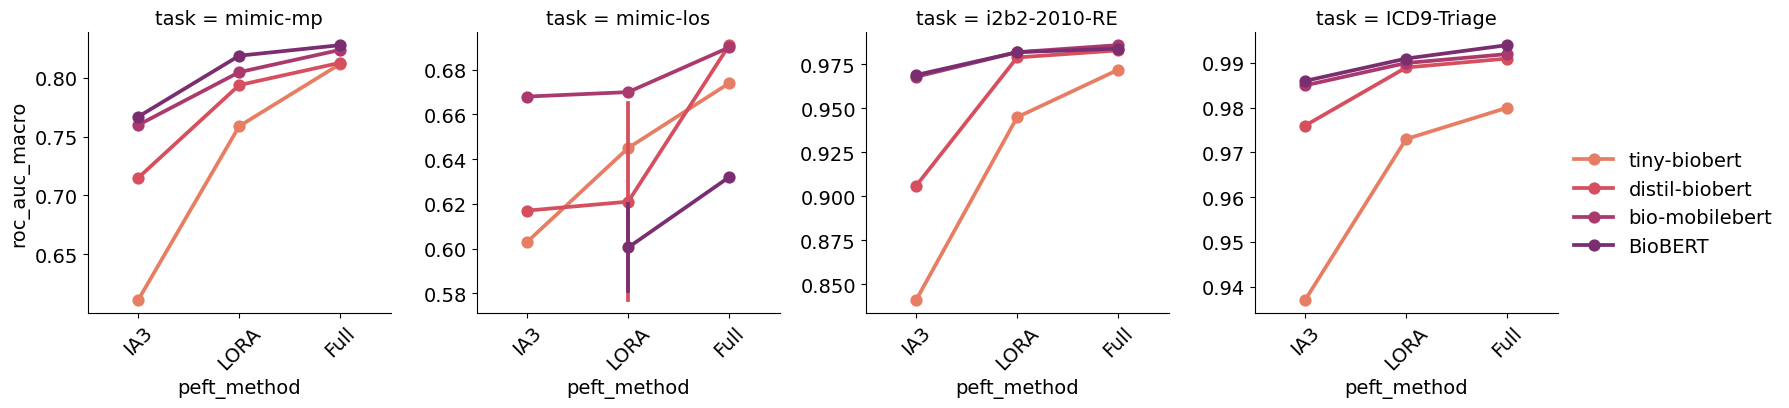

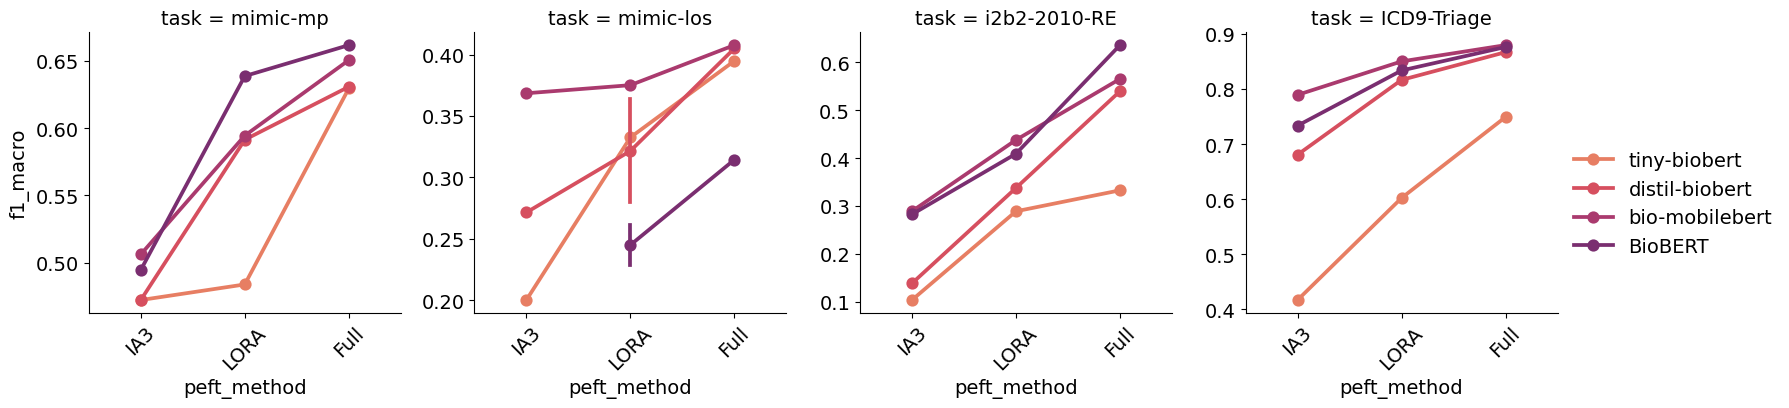

In [13]:


metrics = ['roc_auc_macro', 'f1_macro']

for metric in metrics:
    
    fg = sns.FacetGrid(data=plot_df, col='task', sharey=False, legend_out=True, aspect = 1, height = 4)
    fg.map_dataframe(sns.pointplot, x='peft_method', y=metric, hue='Model name', 
                    order=peft_methods_to_plot, 
                    palette='flare')
    fg.add_legend()
    # handles, labels = fg.axes[0,0].get_legend_handles_labels()
    # fg.fig.legend(handles, labels)
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))
    fg.set_xticklabels(rotation = 45)
    plt.savefig(f'{save_path}/{metric}_peft_methods.png', bbox_inches='tight')
    plt.show()


### Number of trainable parameters

In [17]:
plot_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1_macro,f1_micro,f1_weighted,precision,recall,roc_auc_macro,PEFT_params,PEFT_params_perc,Total_params,log(n_trainable_params)
16,16,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,Full,0.951188,0.887849,0.951188,0.951850,0.886596,0.890325,0.994,0,0.000000,108311810,-inf
17,17,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,LORA,0.946692,0.869578,NaN,0.945702,0.887311,0.863205,0.991,294912,0.272281,108311810,5.469692
23,23,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,i2b2-2010-RE,250.0,Full,0.936651,0.636292,0.936651,0.934578,0.770436,0.613105,0.982,0,0.000000,108311810,-inf
24,24,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,i2b2-2010-RE,250.0,LORA,0.924930,0.406977,0.924930,0.918510,0.516906,0.405804,0.983,294912,0.272281,108311810,5.469692
25,25,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,i2b2-2010-RE,250.0,PREFIX_TUNING,0.916628,0.509811,0.916628,0.915789,0.625991,0.510490,0.985,368640,0.340351,108311810,5.566602


In [14]:
cls_results_df["Model name"].unique()

array(['Bio-ClinicalBERT', 'BioBERT', 'BioLinkBERT-base', 'LinkBERT-base',
       'Mimic-RoBERTa-DeCLUTR', 'RoBERTa-base', 'RoBERTa-mimic',
       'RoBERTa-mimic-note-two-epoch', 'bio-mobilebert', 'distil-biobert',
       'roberta-base-mimic-note-custom_pretraining_contrastive_max_epoch_2_weighted',
       'tiny-biobert'], dtype=object)

In [14]:
plot_df = cls_results_df.loc[cls_results_df['few_shot_n'] > 200].copy()
plot_df =  plot_df.loc[plot_df['task'] != 'mednli']
plot_df = plot_df.loc[plot_df['Model name'].isin(
    ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
plot_df = plot_df.loc[plot_df['peft_method'].isin(peft_methods_to_plot)]
plot_df.sort_values(['Model name', 'peft_method', 'task', 'few_shot_n', 'f1_macro'], 
                            ascending=False, inplace=True)
plot_df.drop_duplicates(['Model name', 'peft_method', 'task', 'few_shot_n'], inplace=True)
plot_df['roc_auc_macro'] = plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

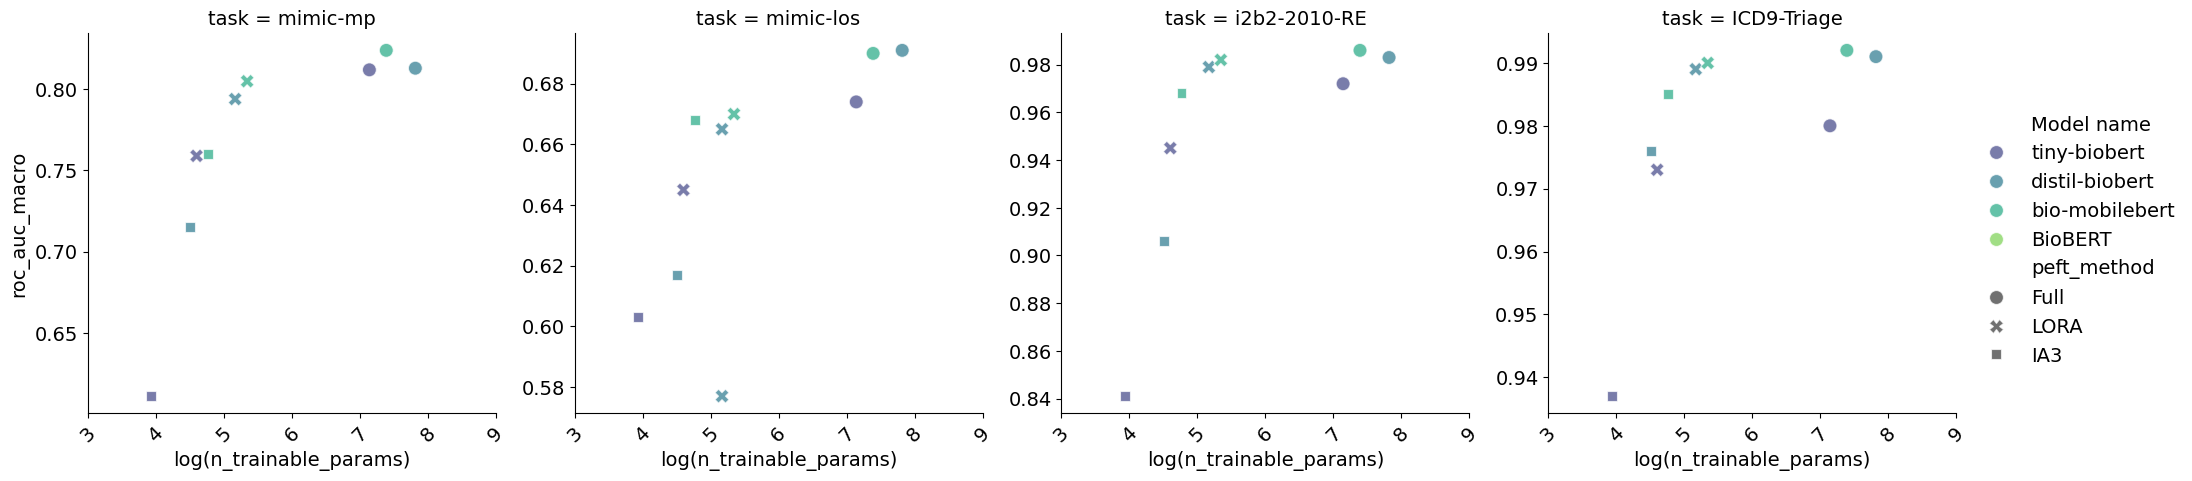

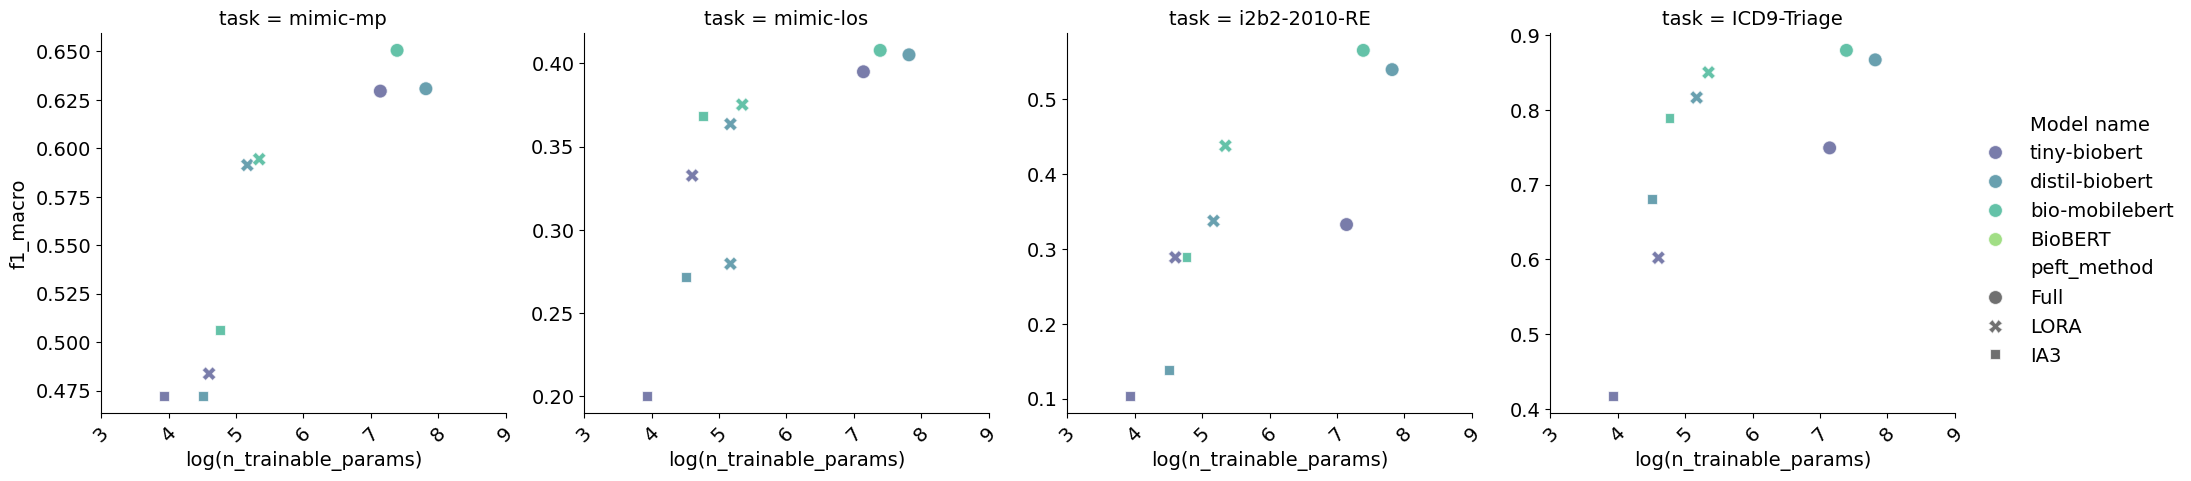

In [16]:
metrics = ['roc_auc_macro', 'f1_macro']
plot_df['log(n_trainable_params)'] = np.log10(plot_df['PEFT_params'])
for metric in metrics:
    # change font size
    
    fg = sns.FacetGrid(data=plot_df, col='task', sharey=False, 
                       sharex=True, legend_out=True, aspect=1, height=5)
    fg.map_dataframe(sns.scatterplot, x='log(n_trainable_params)', y=metric, style='peft_method', 
                     hue='Model name', palette='viridis', s=100, alpha=0.7,
                     style_order=peft_methods_to_plot[::-1])
    # fg.map_dataframe(sns.lineplot, x='log(n_trainable_params)', y=metric, style='peft_method', 
    #                  hue='Model name', palette='viridis', alpha=0.7,
    #                  style_order=['Full', 'PREFIX_TUNING', 'LORA', 'PROMPT_TUNING'])
    fg.add_legend()
    fg.set_xticklabels(rotation = 45)
    plt.savefig(f'{save_path}/{metric}_peft_methods_trainable_params.png', bbox_inches='tight')
    plt.show()


In [44]:
# Plot the lines on two facets
# sns.relplot(
#     data=dots,
#     x="time", y="firing_rate",
#     hue="coherence", size="choice", col="align",
#     kind="line", size_order=["T1", "T2"], palette=palette,
#     height=5, aspect=.75, facet_kws=dict(sharex=False),
# )

In [134]:
plot_df.query("`Model name` == 'Bio-ClinicalBERT' & `task` == 'mimic-los'")

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1_macro,f1_micro,f1_weighted,precision,recall,roc_auc_macro,PEFT_params,PEFT_params_perc,Total_params,log(n_trainable_params)
33,33,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,mimic-los,250.0,Full,0.443862,0.422290,0.443862,0.438665,0.461359,0.415032,0.705,229376,0.211774,108311810,5.360548
34,34,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,mimic-los,250.0,PREFIX_TUNING,0.410840,0.368367,0.410840,0.393162,0.470111,0.362654,0.672,368640,0.340351,108311810,5.566602
35,35,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,mimic-los,250.0,PROMPT_TUNING,0.377591,0.268441,0.377591,0.329927,0.442458,0.289024,0.608,7680,0.007091,108311810,3.885361


### Example plot of f1 macro for specific task and model versus PEFT method 

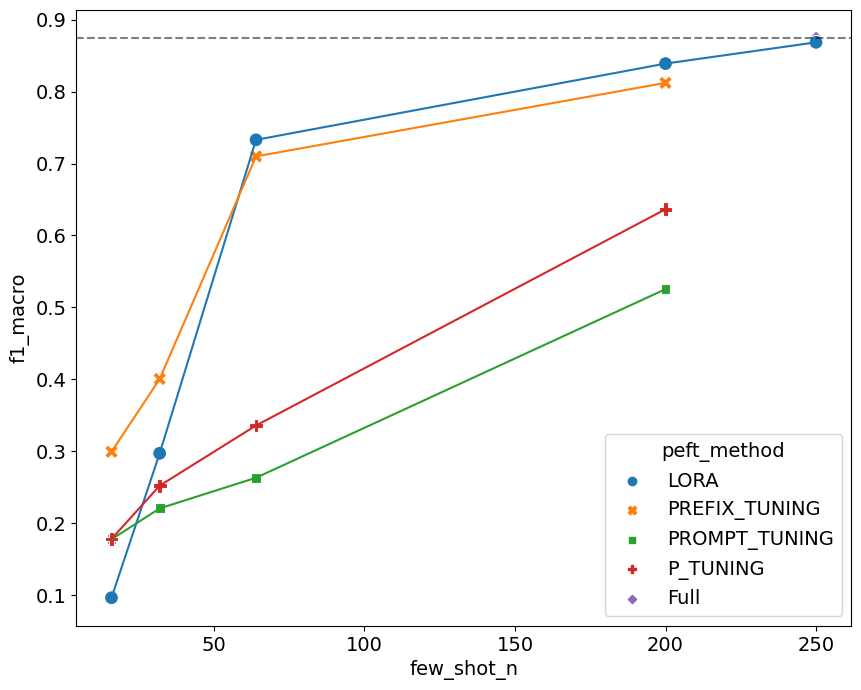

<Figure size 1200x1000 with 0 Axes>

In [16]:
# plot the f1 for one model across few shot sizes and peft method

# some plot params
        # now set x_tick_labels to be used later

# now we want string versions of these to set to xtick labels

task = "ICD9-Triage"

sample_sizes = sorted(set(cls_results_df['few_shot_n'].unique()))
sample_size_x_ticks = [str(x) for x in sample_sizes]

# scatter plot for roberta base vs few shot n with hue as peft method
# plt.figure(figsize=(12,10))

fig, ax = plt.subplots(figsize=(10,8))
g = sns.scatterplot(data = cls_results_df.query("`Model name` == 'roberta-base' & task == @task"),
                    x = "few_shot_n",
                    y = "f1_macro",
                    hue = "peft_method",
                    style = "peft_method",
                    s = 100, ax = ax)

# do same again with point plot

plt.figure(figsize=(12,10))
g = sns.lineplot(data = cls_results_df.query("`Model name` == 'roberta-base' & task == @task"),
                        x = "few_shot_n",
                        y = "f1_macro",
                        hue = "peft_method",
                        ax =ax, 
                        legend = False
)


# draw a horizontal line for the full training set and set at value of peft method with full training set
# and set to same plot as above


ax.axhline(y=cls_results_df.query("`Model name` == 'roberta-base' & task == @task & few_shot_n == 250")["f1_macro"].values[0], color='black', linestyle='--', alpha = 0.5)



           

### Compare multiple models at full sample size

In [17]:
# set models of interest

models_of_interest = ["roberta-base", "Bio_ClinicalBERT", "mimic-roberta-base", "bio-mobilebert", "distil-biobert"]

<Figure size 1200x1000 with 0 Axes>

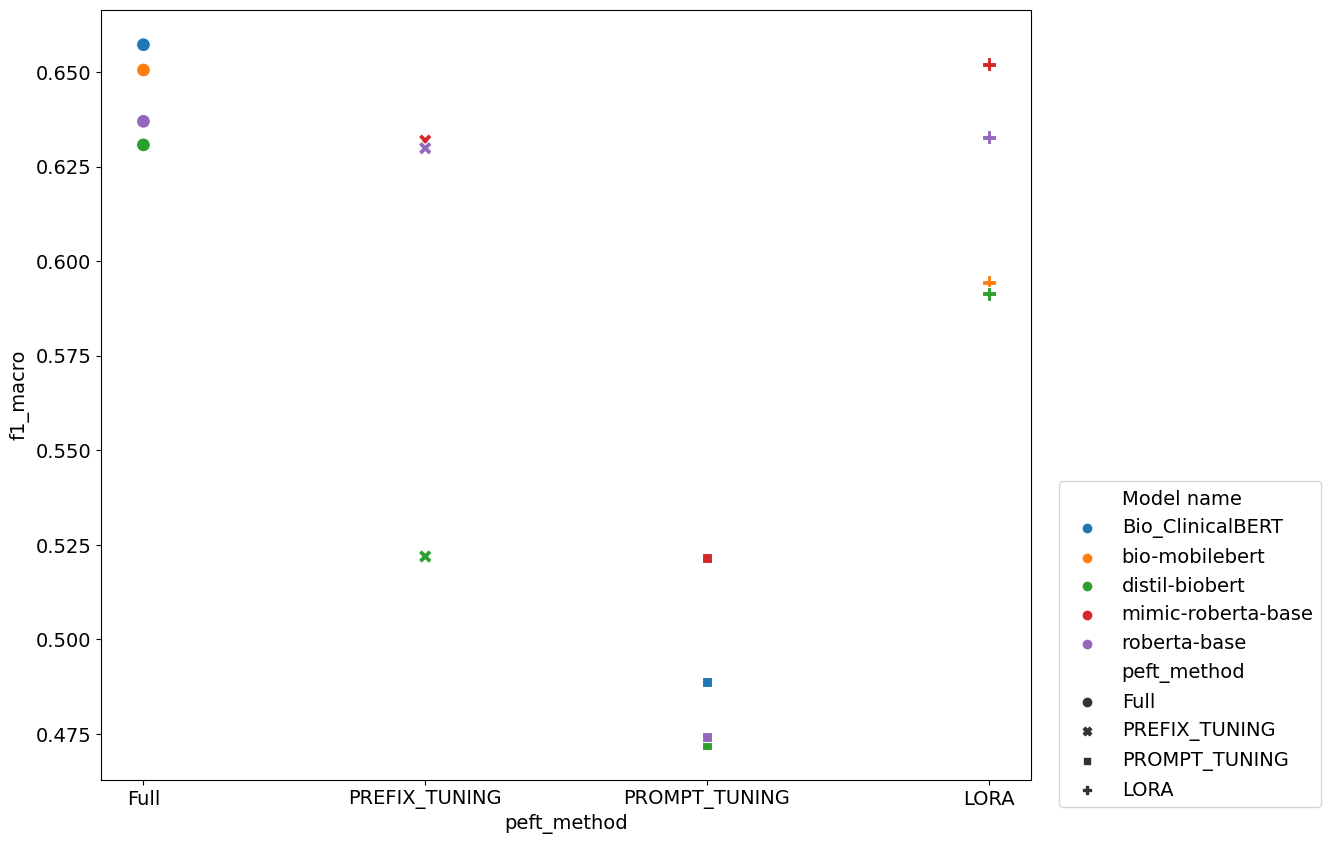

<Figure size 1200x1000 with 0 Axes>

In [18]:
task = "mimic-mp"


# scatter plot for roberta base vs few shot n with hue as peft method
plt.figure(figsize=(12,10))

fig, ax = plt.subplots(figsize=(12,10))
g = sns.scatterplot(data = cls_results_df.query("few_shot_n == 250 & task == @task & `Model name` in @models_of_interest"),
                    x = "peft_method",
                    y = "f1_macro",
                    hue = "Model name",
                    style = "peft_method",
                    s = 100, ax = ax)

# do same again with point plot

plt.figure(figsize=(12,10))
g = sns.lineplot(data = cls_results_df.query("few_shot_n == 250 & task == @task & `Model name` in @models_of_interest"),
                    x = "peft_method",
                    y = "f1_macro",
                    hue = "Model name",
                    style = "peft_method",
                        ax =ax, 
                        legend = False
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))

# draw a horizontal line for the full training set and set at value of peft method with full training set
# and set to same plot as above


# ax.axhline(y=cls_results_df.query("`Model name` == 'roberta-base' & task == @task & few_shot_n == 250")["f1_macro"].values[0], color='black', linestyle='--', alpha = 0.5)

In [31]:
logs_df.task_type.unique()

array(['SEQ_CLS', 'TOKEN_CLS'], dtype=object)

### Look at training time etc

In [33]:
cls_results_df

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1_macro,f1_micro,f1_weighted,...,recall,roc_auc_macro,train/total_flos,train/train_loss,train/train_runtime,train/train_samples_per_second,train/train_steps_per_second,PEFT_params,PEFT_params_perc,Total_params
0,0,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,Full,0.948940,0.879353,0.948940,0.949106,...,0.885844,0.993043,1.178996e+16,0.182213,1151.783691,41.497002,1.298,108310272.0,99.998580,108311810.0
1,1,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,IA3,0.904303,0.661928,0.904303,0.889988,...,0.656008,0.982280,1.179958e+16,0.508661,1016.591003,47.014999,1.471,64512.0,0.059561,108311810.0
2,2,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,LORA,0.948298,0.876338,0.948298,0.948010,...,0.874291,0.991595,1.183130e+16,0.281233,973.616028,49.090000,1.536,294912.0,0.272281,108311810.0
3,3,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,PREFIX_TUNING,0.758831,0.377884,0.758831,0.702254,...,0.370109,0.904001,1.179070e+16,0.945242,911.373108,52.443001,1.640,184320.0,0.170175,108311810.0
4,4,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,ICD9-Triage,250.0,PROMPT_TUNING,0.724470,0.309875,0.724470,0.646503,...,0.328047,0.892517,1.179070e+16,1.019554,930.424622,51.368999,1.607,7680.0,0.007091,108311810.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,328,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250.0,IA3,0.894458,0.472145,0.894458,0.844627,...,0.500000,0.610758,2.286669e+15,0.338250,628.517273,270.112000,8.448,8544.0,0.061579,13874762.0
329,329,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250.0,LORA,0.895273,0.483743,0.895273,0.847377,...,0.505564,0.758608,2.302018e+15,0.310653,592.793823,286.390015,8.958,39936.0,0.287832,13874762.0
330,330,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250.0,PREFIX_TUNING,0.894662,0.484691,0.894662,0.846581,...,0.505162,0.737646,2.282492e+15,0.317243,778.098083,218.186005,6.824,24960.0,0.179895,13874762.0
331,331,tiny-biobert,nlpie/tiny-biobert,mimic-mp,250.0,PROMPT_TUNING,0.894458,0.472145,0.894458,0.844627,...,0.500000,0.608066,2.282492e+15,0.335948,878.742371,193.197006,6.043,3120.0,0.022487,13874762.0


In [36]:
time_grouped_df = cls_results_df.groupby(["Model name", 
                                          "peft_method",
                                          "task",
                                          "few_shot_n"])[["train/train_runtime","train/total_flos", "f1_macro"]].mean().reset_index()

In [71]:
time_grouped_df.query("`Model name` == 'tiny-biobert' & task == 'mimic-los'")

tag,Model name,peft_method,task,few_shot_n,train/train_runtime,train/total_flos,f1_macro
290,tiny-biobert,Full,mimic-los,250.0,672.981689,2.044993e+15,0.394912
295,tiny-biobert,IA3,mimic-los,250.0,567.254883,2.049284e+15,0.200045
305,tiny-biobert,LORA,mimic-los,16.0,50.236301,4.340235e+12,0.082366
306,tiny-biobert,LORA,mimic-los,32.0,51.597698,8.680469e+12,0.117975
307,tiny-biobert,LORA,mimic-los,64.0,52.520100,1.736094e+13,0.185895
308,tiny-biobert,LORA,mimic-los,128.0,57.049000,3.472188e+13,0.229567
309,tiny-biobert,LORA,mimic-los,200.0,61.754700,5.425293e+13,0.239175
310,tiny-biobert,LORA,mimic-los,250.0,529.658508,2.063036e+15,0.332569
320,tiny-biobert,PREFIX_TUNING,mimic-los,250.0,696.214905,2.045541e+15,0.303347
325,tiny-biobert,PROMPT_TUNING,mimic-los,250.0,784.993591,2.045541e+15,0.200091


In [37]:
time_grouped_df.query("peft_method == 'LORA' and few_shot_n == 250")

tag,Model name,peft_method,task,few_shot_n,train/train_runtime,train/total_flos,f1_macro
10,Bio-ClinicalBERT,LORA,ICD9-Triage,250.0,973.616028,1.183130e+16,0.876338
16,Bio-ClinicalBERT,LORA,i2b2-2010-RE,250.0,1168.505249,1.361401e+16,0.406977
17,Bio-ClinicalBERT,LORA,mednli,250.0,217.321594,3.172938e+15,0.266870
21,Bio-ClinicalBERT,LORA,mimic-los,250.0,2841.795898,3.765043e+16,0.400606
23,Bio-ClinicalBERT,LORA,mimic-mp,250.0,3164.370850,4.202153e+16,0.636708
44,BioLinkBERT-base,LORA,i2b2-2010-RE,250.0,1608.011230,1.207389e+16,0.468533
45,BioLinkBERT-base,LORA,mednli,250.0,281.238190,2.614242e+15,0.269277
46,BioLinkBERT-base,LORA,mimic-los,250.0,2780.993896,3.765043e+16,0.411788
47,BioLinkBERT-base,LORA,mimic-mp,250.0,3105.887695,4.202153e+16,0.651606
68,LinkBERT-base,LORA,i2b2-2010-RE,250.0,1858.796143,1.368241e+16,0.369720


In [39]:
# peft_methods_to_plot = ['PROMPT_TUNING', 'PREFIX_TUNING', 'LORA', 'IA3', 'Full']
peft_methods_to_plot = ['PREFIX_TUNING','IA3', 'LORA', 'Full']
plot_df = cls_results_df.loc[cls_results_df['few_shot_n'] > 200].copy()
plot_df = plot_df.loc[plot_df['Model name'].isin(
    ['distil-biobert', 'bio-mobilebert', 'tiny-biobert', 'BioBERT'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
# subset to only the peft methods we want to plot
plot_df = plot_df.loc[plot_df['peft_method'].isin(peft_methods_to_plot)]

plot_df.sort_values(['Model name', 'peft_method', 'task', 'few_shot_n', 'roc_auc_macro'], 
                            ascending=False, inplace=True)
plot_df.drop_duplicates(['Model name', 'peft_method', 'task', 'few_shot_n'], inplace=True)
plot_df['roc_auc_macro'] = plot_df['roc_auc_macro'].apply(lambda x: round(x, 3)).values

In [40]:
cls_results_df["Model name"].unique()

array(['Bio-ClinicalBERT', 'BioBERT', 'BioLinkBERT-base', 'LinkBERT-base',
       'Mimic-RoBERTa-DeCLUTR', 'RoBERTa-base', 'RoBERTa-mimic',
       'RoBERTa-mimic-note-two-epoch', 'bio-mobilebert', 'distil-biobert',
       'roberta-base-mimic-note-custom_pretraining_contrastive_max_epoch_2_weighted',
       'tiny-biobert'], dtype=object)

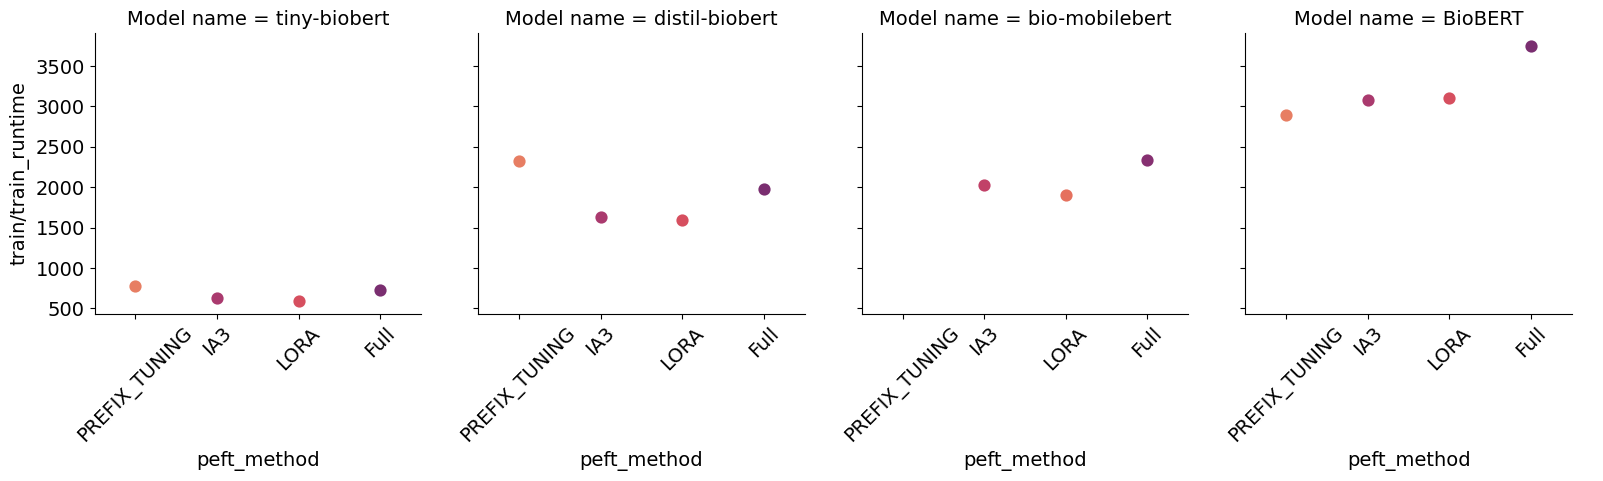

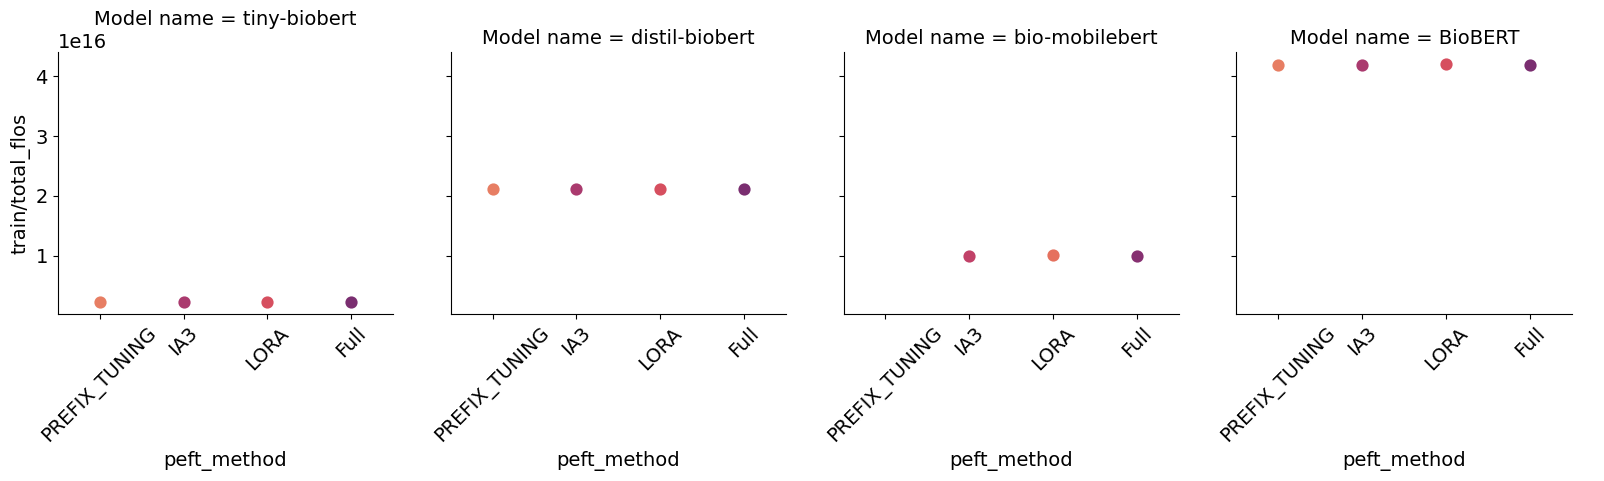

In [41]:
task = "mimic-mp"

metrics = ["train/train_runtime","train/total_flos"]

for metric in metrics:
    
    fg = sns.FacetGrid(data=plot_df.query("task == @task"), col='Model name', sharey=True, legend_out=True, aspect = 1, height = 4)
    fg.map_dataframe(sns.pointplot, x='peft_method', y=metric, hue='peft_method', 
                    order=peft_methods_to_plot, 
                    palette='flare')
    fg.add_legend()
    # handles, labels = fg.axes[0,0].get_legend_handles_labels()
    # fg.fig.legend(handles, labels)
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))
    fg.set_xticklabels(rotation = 45)
    plt.show()

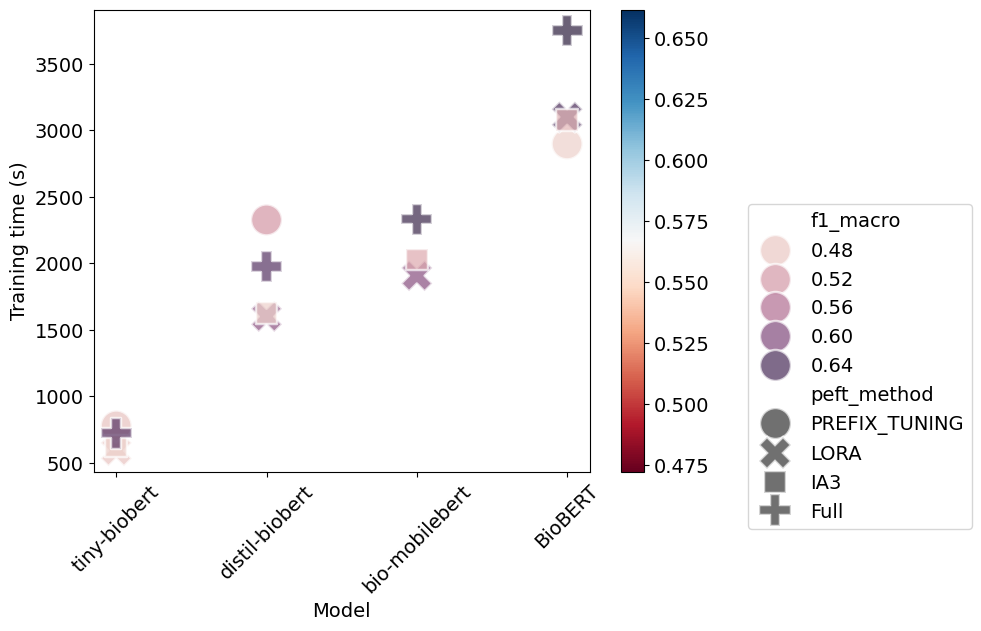

In [47]:
# make plot
plt.figure(figsize=(8, 6))
cls_metric = "f1_macro"
peft_type = "LORA"
time_plot_df = plot_df.query("task == @task and peft_method == @peft_type")
time_plot_df = plot_df.query("task == @task")
ax = sns.scatterplot(data = time_plot_df,
                     x = "Model name",
                     y = "train/train_runtime",
                     hue = cls_metric,
                     style="peft_method",
                     s = 500,
                     alpha = 0.7,
                     
                     )
norm = plt.Normalize(time_plot_df[cls_metric].min(), time_plot_df[cls_metric].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])
# Remove the legend and add a colorbar
# ax.get_legend().remove()
ax.figure.colorbar(sm, ax=ax)
# plt.suptitle(f"Alignment vs Uniformity for label {label}")
plt.xlabel("Model")
# rotate x tick labels by 45
plt.xticks(rotation=45)
plt.ylabel("Training time (s)")

    # for line in range(0,uniform_align_dfs.shape[0]):
    #     # print(f"line {line}")
    #     plt.text(uniform_align_dfs.iloc[line].uniform_loss+0.002, uniform_align_dfs.iloc[line].align_loss+0.02, uniform_align_dfs.iloc[line].model_name, horizontalalignment='center', size='medium', color='black', weight='semibold')
# texts = []
# for line in range(0,time_plot_df.shape[0]):
#     texts.append(plt.text(time_plot_df.iloc[line]["train/train_runtime"]+0.002,
#                           time_plot_df.iloc[line]["train/train_runtime"]+0.02,
#                           time_plot_df.iloc[line]["Model name"],
#                           horizontalalignment='left',
#                           size='medium',
#                           color='black',
#                           weight='semibold'))


# adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red'))
# adjust_text(texts)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.3, 0.6))
plt.savefig(f'{save_path}/{cls_metric}_peft_methods_train_time.png', bbox_inches='tight')
plt.show()

## Sensitivity analysis


### Fewshot sampling vs performance

In [ ]:
fs_logs_dir = "/mnt/sdd/efficient_ml_data/saved_models/peft/fewshot_sensitivity/logs"

### Lora Rank 

In [65]:
lr_logs_dir = "/mnt/sdd/efficient_ml_data/saved_models/peft/lora_rank_analysis/logs/" # need last backslash
lora_logs_df = read_tb_files(lr_logs_dir)

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/40434 [00:00<?, ?it/s]

In [ ]:
lora_logs_df.head()

In [ ]:
cls_results_df = produce_results_table(logs_df, 
                                        metric = ["f1",
                                                  "accuracy",
                                                  "precision",
                                                  "recall",
                                                  "auc", 
                                                   "train/total_flos", "train/train_loss",
                                                "train/train_runtime", "train/train_samples_per_second",
                                                "train/train_steps_per_second"],
                                        mode = "all",
                                        groupby_list = ["Model name", "model_name_or_path", "task","few_shot_n", "peft_method"],
                                        task_type = "SEQ_CLS",
                                        value_aggregate_method = "max",
                                        )

# NER tasks

In [18]:
ner_results_df.head()

tag,index,Model name,model_name_or_path,task,few_shot_n,peft_method,accuracy,f1,precision,recall
0,0,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,i2b2-2010-NER,250.0,Full,0.937673,0.843558,0.841821,0.852396
1,1,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,i2b2-2010-NER,250.0,LORA,0.920507,0.770119,0.767460,0.772798
2,2,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,i2b2-2012-NER,250.0,Full,0.914369,0.841927,0.835017,0.853659
3,3,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,i2b2-2012-NER,250.0,LORA,0.892563,0.791017,0.772709,0.813864
4,4,Bio-ClinicalBERT,emilyalsentzer/Bio_ClinicalBERT,i2b2-2014-NER,250.0,Full,0.996175,0.962993,0.968270,0.957774


In [19]:
ner_results_df["Model name"].unique()

array(['Bio-ClinicalBERT', 'BioBERT', 'BioLinkBERT-base',
       'Mimic-RoBERTa-DeCLUTR', 'RoBERTa-base', 'RoBERTa-mimic',
       'RoBERTa-mimic-note-two-epoch', 'all-mpnet-base-v2',
       'bio-mobilebert', 'declutr-base', 'distil-biobert', 'tiny-biobert'],
      dtype=object)

In [59]:
plot_df = ner_results_df.loc[ner_results_df['few_shot_n'] > 200].copy()

plot_df = plot_df.loc[plot_df['Model name'].isin(
    ['BioBERT','distil-biobert','bio-mobilebert', 'tiny-biobert'])] # , 'distil-biobert', 'bio-mobilebert', 'Bio-ClinicalBERT', 'tiny-biobert'
plot_df = plot_df.loc[plot_df['peft_method'].isin(peft_methods_to_plot)]
plot_df.sort_values(['Model name', 'peft_method', 'task', 'few_shot_n', 'f1'], 
                            ascending=False, inplace=True)
plot_df.drop_duplicates(['Model name', 'peft_method', 'task', 'few_shot_n'], inplace=True)


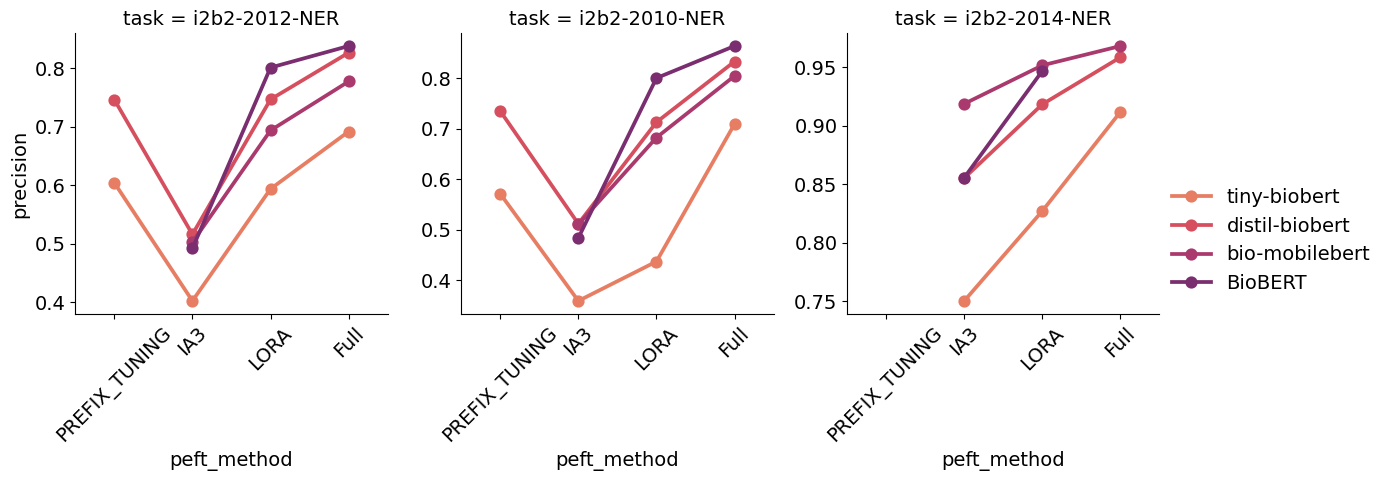

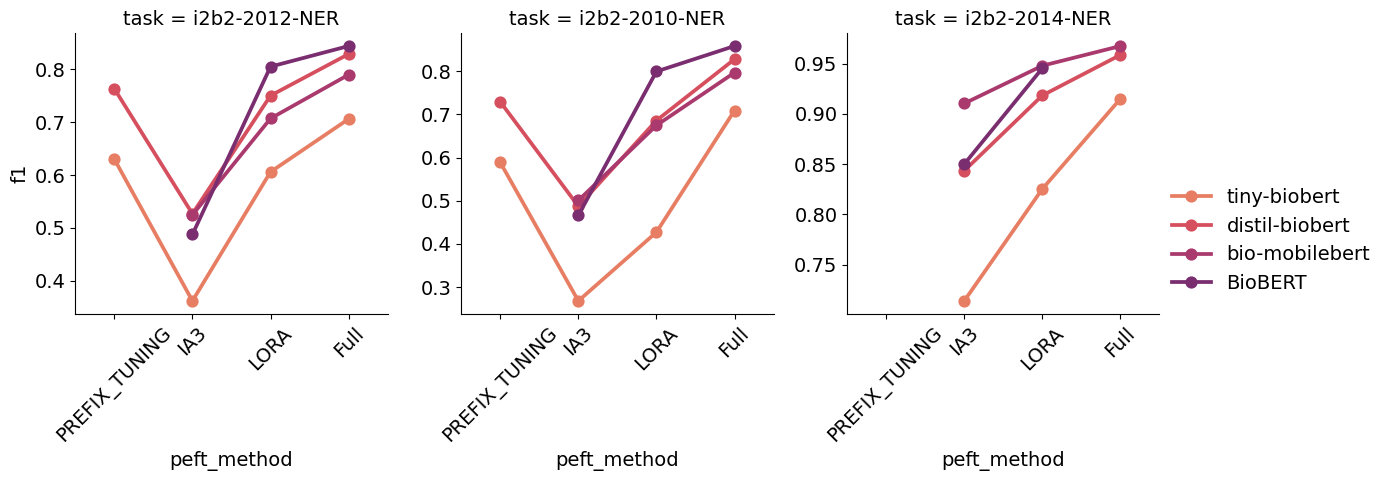

In [60]:
metrics = ['precision', 'f1']

  
for metric in metrics:
    
    fg = sns.FacetGrid(data=plot_df, col='task', sharey=False, legend_out=True, aspect = 1, height = 4)
    fg.map_dataframe(sns.pointplot, x='peft_method', y=metric, hue='Model name', 
                    order=peft_methods_to_plot, 
                    palette='flare')
    fg.add_legend()
    # handles, labels = fg.axes[0,0].get_legend_handles_labels()
    # fg.fig.legend(handles, labels)
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))
    fg.set_xticklabels(rotation = 45)
    # plt.savefig(f'{save_path}/NER_{metric}_peft_methods.png', bbox_inches='tight')
    plt.show()

### Model comparison

In [24]:
models_of_interest

['roberta-base',
 'Bio_ClinicalBERT',
 'mimic-roberta-base',
 'bio-mobilebert',
 'distil-biobert']

In [35]:
# ner_results_df.query("task == @task")

<Figure size 1200x1000 with 0 Axes>

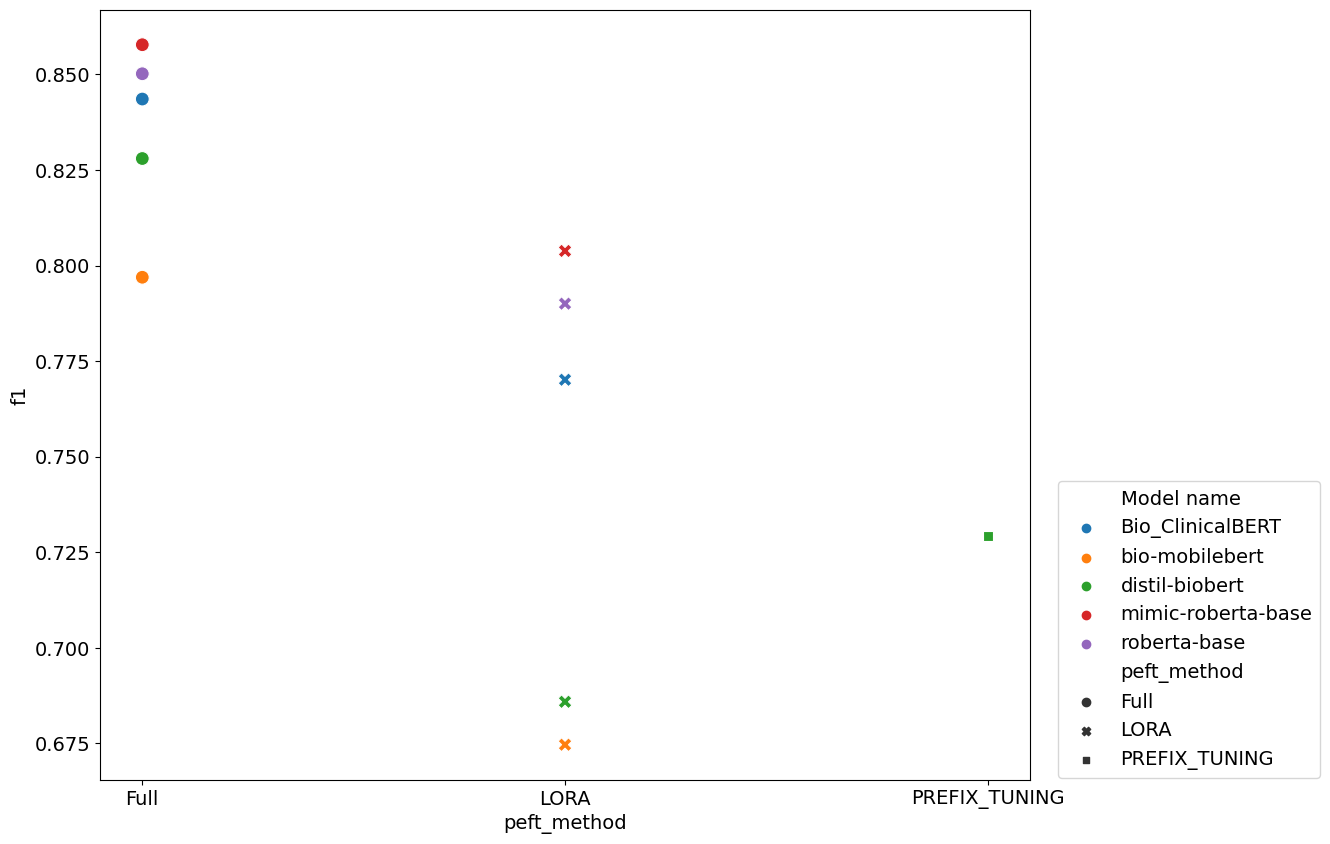

<Figure size 1200x1000 with 0 Axes>

In [38]:

task = "i2b2-2010-NER"

sample_sizes = sorted(set(ner_results_df['few_shot_n'].unique()))
sample_size_x_ticks = [str(x) for x in sample_sizes]

metric = "f1"

# scatter plot for roberta base vs few shot n with hue as peft method
plt.figure(figsize=(12,10))

fig, ax = plt.subplots(figsize=(12,10))
g = sns.scatterplot(data = ner_results_df.query("task == @task & `Model name` in @models_of_interest"),
                    x = "peft_method",
                    y = metric,
                    hue = "Model name",
                    style = "peft_method",
                    s = 100, ax = ax,
                    )

# do same again with point plot

plt.figure(figsize=(12,10))
g = sns.lineplot(data = ner_results_df.query("task == @task & `Model name` in @models_of_interest"),
                        x = "peft_method",
                        y = metric,
                        hue = "Model name",
                        style = "peft_method",
                        ax =ax, 
                        legend = False
)


sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 0.4))



### Can also look at averages across tasks

not sure if good idea or not, but may be useful to look at averages across tasks

In [ ]:
results_df = produce_results_table(logs_df, 
                                        metric = ["f1_macro","accuracy"],
                                        mode = "eval",
                                        groupby_list = ["Model name", "few_shot_n", "peft_method"],
                                        tasks = ["icd9-triage-no-category-in-text","mimic-mp"],
                                        value_aggregate_method = "max",
                                        )

#### random debugging

In [103]:
from scipy.special import softmax as sk_softmax
# load softmax from pytorch
from torch.nn.functional import softmax

In [104]:
faulty_logits =  [26443.322, 26029.15, 23799.176, 12593.839, 22744.002, 20037.562, 30538.14, 21639.273, 30558.88]

In [106]:
np.sum(sk_softmax(faulty_logits))

1.0000000000011509

In [119]:
import evaluate

In [84]:
# convert faulty logits to tensor
logits = torch.tensor(faulty_logits)

In [88]:
logits

tensor([26443.3223, 26029.1504, 23799.1758, 12593.8389, 22744.0020, 20037.5625,
        30538.1406, 21639.2734, 30558.8809])

In [87]:
sk_softmax(logits)

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        9.8317e-10, 0.0000e+00, 1.0000e+00])

In [86]:
softmax(logits)

/tmp/ipykernel_39749/3615344952.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(logits)


tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        9.8317e-10, 0.0000e+00, 1.0000e+00])

In [97]:
working_logits = [25719.342, 25567.707, 23205.53, 12138.746, 22023.115, 19547.37, 29444.035, 21317.316, 29743.26]

In [96]:
softmax(torch.tensor(working_logits))

/tmp/ipykernel_39749/2639681039.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(torch.tensor(working_logits))


tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [94]:
np.max(faulty_logits)

30558.88

In [93]:
working_logits

[25719.342,
 25567.707,
 23205.53,
 12138.746,
 22023.115,
 19547.37,
 29444.035,
 21317.316,
 29743.26]

In [107]:
from torchmetrics import AUROC

In [128]:
# faulty labels

faulty_labels = np.zeros_like(faulty_logits)
faulty_labels[5] = 1

In [181]:
auroc = AUROC(task =  "binary", threshold = 0.5)
multi_auroc = AUROC(task = "multiclass", num_classes=9)

In [118]:
faulty_logits

[26443.322,
 26029.15,
 23799.176,
 12593.839,
 22744.002,
 20037.562,
 30538.14,
 21639.273,
 30558.88]

In [117]:
auroc(torch.tensor((faulty_logits)), torch.tensor(faulty_labels))

/mnt/sdc/niallt/venvs/39nlp/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)


tensor(0.)

In [177]:
hf_roc_auc = evaluate.load("roc_auc", "multiclass")

In [123]:
faulty_scores = sk_softmax(faulty_logits)

In [125]:
faulty_labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [124]:
faulty_scores

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.83405074e-10, 0.00000000e+00,
       9.99999999e-01])

In [130]:
hf_roc_auc.compute(references=faulty_labels,
                                            prediction_scores = faulty_scores,
                                            multi_class = 'ovr', 
                                            average = "macro")['roc_auc']

0.375

In [139]:
import numpy as np

# Open file 
data = []
with open('../faulty_logits.txt') as f:
  # Read lines
  lines = f.read().split('\n')

data = [d.split(',') for d in lines]
data = np.array(data, dtype=np.float32)
print(data)

[[26443.322 26029.15  23799.176 ... 30538.14  21639.273 30558.88 ]
 [25855.453 25518.928 23285.416 ... 29789.299 21231.01  29885.418]
 [26724.164 26196.896 24030.08  ... 30973.979 21752.494 30876.074]
 ...
 [20373.922 19027.521 18072.285 ... 24537.35  15531.233 23401.838]
 [28499.885 27426.361 25497.64  ... 33555.13  22613.291 32864.805]
 [24578.404 23902.756 22054.492 ... 28687.58  19786.752 28377.973]]


In [158]:

faulty_labels = np.random.randint(0, len(data[0]), size=len(data))


In [162]:
faulty_labels.max()

8

In [144]:
faulty_labels.shape

(43000, 9)

In [170]:
faulty_scores = sk_softmax(data, axis = -1)

In [171]:
faulty_scores

array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 9.831747e-10,
        0.000000e+00, 1.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.803471e-42,
        0.000000e+00, 1.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 3.026805e-43],
       ...,
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 1.000000e+00,
        0.000000e+00, 0.000000e+00]], dtype=float32)

In [172]:
faulty_scores.shape

(43000, 9)

In [174]:
faulty_labels

(43000,)

In [186]:
torch.tensor(faulty_scores).shape

torch.Size([43000, 9])

In [187]:
multi_auroc(torch.tensor(faulty_scores), torch.tensor(faulty_labels))

tensor(0.5000)

In [178]:
hf_roc_auc.compute(references=faulty_labels,
                    prediction_scores = faulty_scores,
                    multi_class = 'ovr', 
                    average = "macro")['roc_auc']

ValueError: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes